In [ ]:
c = {'May31':
'Two crises convulse a nation: a pandemic and police violence',
'May30a':
'Nation’s first astronaut launch to orbit from home soil in nearly a decade',
'May30b':
'Death of George Floyd at the hands of police set off protests',
'May27':
'SpaceX launch of NASA astronauts is postponed over weather'}

In [ ]:
import spacy
from spacy import displacy # Install dataset: python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [ ]:
doc0 = nlp('Two crises convulse a nation')

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

doc = nlp("Your input text goes here.")

svg = displacy.render(doc, style="dep", jupyter=False)

with open('sentence0.svg', 'w', encoding='utf-8') as f:
    f.write(svg)

In [ ]:
doc1 = nlp('SpaceX launch of NASA astronauts is postponed over weather')
displacy.render(doc1, style='ent', jupyter=True, options={'distance':90})

In [ ]:
[w.lemma_ for w in doc1 if not w.is_stop]

['SpaceX', 'launch', 'NASA', 'astronaut', 'postpone', 'weather']

In [ ]:
import pandas as pd
from scipy.sparse import lil_matrix
d = {}
for j, dok in enumerate(c.keys()):
    tokens = [w.lemma_ for w in nlp(c[dok])
              if not w.is_stop and w.pos_ != 'PUNCT']
    for t in tokens:

        d[t] = d.setdefault(t, [])
        d[t] += [j]
A = lil_matrix((len(d.keys()), len(c.keys())), dtype=int)
for i, t in enumerate(d.keys()):
    for j in d[t]:
        A[i, j] = 1
Adf = pd.DataFrame(A.toarray(), index=d.keys(), columns=c.keys()); Adf

,May31,May30a,May30b,May27
crisis,1,0,0,0
convulse,1,0,0,0
nation,1,1,0,0
pandemic,1,0,0,0
police,1,0,1,0
violence,1,0,0,0
astronaut,0,1,0,1
launch,0,1,0,1
orbit,0,1,0,0
home,0,1,0,0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set();
from numpy.linalg import norm
from scipy.linalg import svd

In [ ]:

u, s, vt = svd(A.toarray())

In [ ]:
k = 2 # Limit to rank k
Vt = vt[:k, :]
pd.DataFrame(Vt, columns=c.keys()) # Documents as k-vectors

,May31,May30a,May30b,May27
0,0.269907,0.829243,0.109002,0.477101
1,0.458490,-0.149538,0.854138,-0.194611


In [ ]:
US = u[:, :k] @ np.diag(s[:k])
usp = pd.DataFrame(US, index=d.keys()) # Words as k-vectors
usp.head()

,0,1
crisis,0.269907,0.458490
convulse,0.269907,0.458490
nation,1.099150,0.308952
pandemic,0.269907,0.458490
police,0.378909,1.312628


In [ ]:
astronaut = usp.loc['astronaut', :].to_numpy()
crisis = usp.loc['crisis', :].to_numpy()
police = usp.loc['police', :].to_numpy()

In [ ]:
crisis.dot(police) / norm(police) / norm(crisis)

0.9686558216875333

In [ ]:
crisis.dot(astronaut) / norm(astronaut) / norm(crisis)

0.27103529721595343

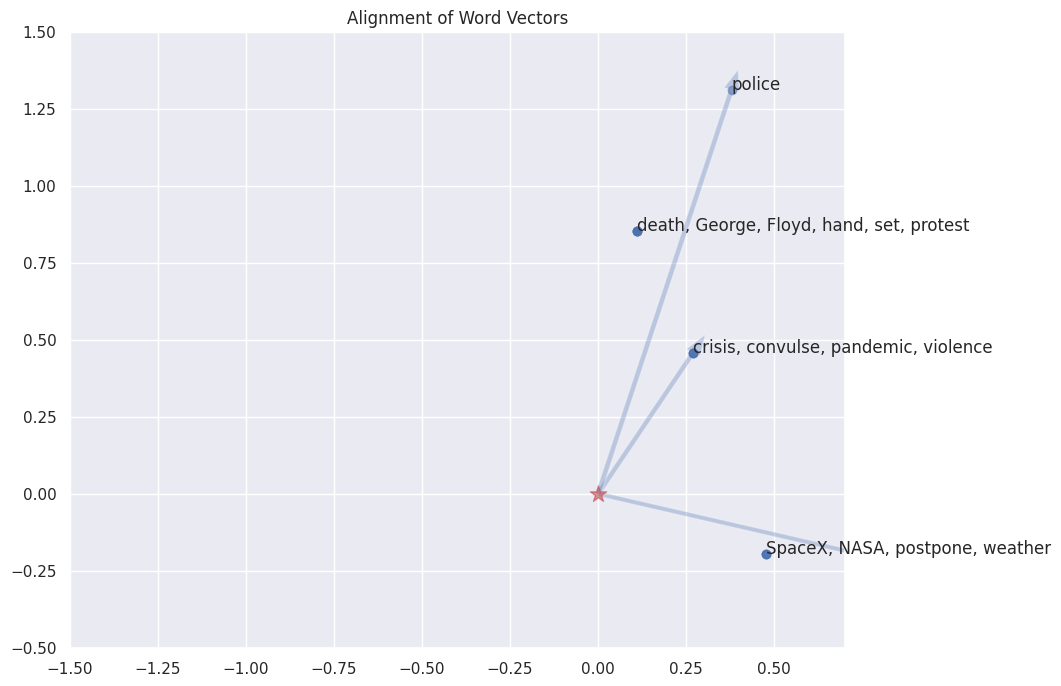

In [ ]:
w = {}; us = np.round(US, 8) # w[(x,y)] = list of words at that point
usr = list(set([tuple(us[i, :]) for i in range(us.shape[0])]))
for i in range(len(usr)):
    w[usr[i]] = []
    for j in range(usp.shape[0]):
        if norm(usp.iloc[j, :] - usr[i]) < 1e-6:
            w[usr[i]] += [usp.index[j]]
fig = plt.figure(figsize=(10, 8)); ax = fig.gca()
ax.arrow(0, 0, crisis[0], crisis[1],width=0.015, alpha=0.3)
ax.arrow(0, 0, police[0], police[1],width=0.015, alpha=0.3)
ax.arrow(0, 0, astronaut[0], astronaut[1], width=0.015, alpha=0.3)
ax.scatter(US[: , 0], US[: ,1], alpha=0.5)
ax.scatter(0, 0, color='r', marker='*', s=150, alpha=0.6);
for i, key in enumerate(w.keys()):
    ax.annotate(', '.join(w[key]), (key[0], key[1]))
ax.set_xlim((-1.5, 0.7)); ax.set_ylim((-0.5, 1.5));
ax.set_title('Alignment of Word Vectors');

In [ ]:
c.update(
{
'May30Launch':
'Go NASA! Go SpaceX! Godspeed, Bob and Doug!',
'NYTimes':
'NASA and SpaceX officials more often than not ' +
'just call the pilots of this historic mission Bob and Doug.',

'May30NASAblog':
'The first stage of the SpaceX rocket has landed ' +
'successfully on the droneship, Of Course I Still Love You.',
'May31NYTimes':
'After a 19 hour trip, NASA astronauts Bob and Doug ' +
'successfully docked their capsule and entered the space station.',
})

In [ ]:
 c.update(
{
'2015Musk':
'West Coast droneship under construction will ' +
'be named Of Course I Still Love You',
'IainBanks':
'These friends of yours are ships. ' +
'Yes, both of them. ' +
'What are they called? ' +
'Of Course I Still Love You and Just Read The Instructions. ' +
'They are not warships? ' +
'With names like that?'
})

In [ ]:
from spacy.matcher import PhraseMatcher
terms = ['SpaceX',
'Of Course I Still Love You',
'Just Read The Instructions']
patterns = [nlp.make_doc(text) for text in terms]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('TerminologyList', None, *patterns)

In [ ]:
from spacy.tokens import Span
def tokensfromdoc(doc):
    d = nlp(doc)
    matches = matcher(d)
    for match_id, start, end in matches:
        term = Span(d, start, end, label='myterms')
        d.ents = list(d.ents) + [term]
    tokens = [w.lemma_ for w in d
              # no pronouns
              if w.pos_ != 'PRON'\
              # no punctuations
              and w.pos_ != 'PUNCT' \
              # not Beginning of a named entity
              and w.ent_iob_ != 'B' \
              # not Inside a named entity
              and w.ent_iob_ != 'I' \
              # not a stop word
              and not w.is_stop]

    tokens += [de.text.rstrip().replace(' ', '_') for de in d.ents]

    return tokens
def dictokens(corpora):
    d = {}
    for j, dok in enumerate(corpora.keys()):
        for t in tokensfromdoc(corpora[dok]):
            d[t] = d.setdefault(t, [])
            d[t] += [j]
    return d

In [ ]:
def tdmatrix(d, corpora):
    A = lil_matrix((len(d.keys()), len(corpora.keys())), dtype=int)
    for i, t in enumerate(d.keys()):
        for j in d[t]:

            A[i, j] = 1
    return A

In [ ]:
d = dictokens(c)

In [ ]:
d = dictokens(c)
A = tdmatrix(d, c)
Adf = pd.DataFrame(A.toarray(), index=d.keys(), columns=c.keys())

In [ ]:
Adf.loc[['Of_Course_I_Still_Love_You'], 'NYTimes':].T

,Of_Course_I_Still_Love_You
NYTimes,0
May30NASAblog,1
May31NYTimes,0
2015Musk,1
IainBanks,1


In [ ]:
def retrieve(querytokns, W, Vt, c):
    """Given a list of query word token numbers "querytokns",
    all words vectors "W" and all document vectors "Vt.T"
    extracted from a corpus c, retrieve the documents
    relevant to the query. """
    q = W[querytokns, :].mean(axis=0)
    nrm = norm(q)
    q /= nrm
    idx = np.argsort(Vt.T @ q)[::-1]
    kl = list(c.keys())
    keys = [kl[i] for i in idx]
    docs = [c[k] for k in keys]
    return docs,keys,idx

In [ ]:
uu, ss, vvt = svd(A.toarray()) # SVD & rank k approximation
k = 4
U = uu[:, :k]; S = ss[:k];
Vt = vvt[:k, :] # Document vectors
W = uu[:, :k] @ np.diag(ss[:k]) # Word vectors

In [ ]:
myquery = np.where((Adf.index=='astronaut') | (Adf.index=='first'))[0]
docs, keys, idx = retrieve(myquery, W, Vt, c)
docs[:3]

['Nation’s first astronaut launch to orbit from home soil in nearly a decade',
 'SpaceX launch of NASA astronauts is postponed over weather',
 'The first stage of the SpaceX rocket has landed successfully on the droneship, Of Course I Still Love You.']

In [ ]:
myquery = np.where(Adf.index=='droneship')[0]
docs, keys, idx = retrieve(myquery, W, Vt, c)
docs[:3]

['The first stage of the SpaceX rocket has landed successfully on the droneship, Of Course I Still Love You.',
 'These friends of yours are ships. Yes, both of them. What are they called? Of Course I Still Love You and Just Read The Instructions. They are not warships? With names like that?',
 'West Coast droneship under construction will be named Of Course I Still Love You']